# FFF Step 2: Scaffold selection

## Pre-requisites

- [ ] BulkDock & HIPPO set up for Target
- [ ] Algorithmic merges generated and placed
- [ ] Merges uploaded to Fragalysis and curated

In [5]:
%load_ext autoreload
%autoreload 2
import hippo
from os import environ, system
from pathlib import Path
import pandas as pd
import json
from mrich import print
import mrich
import shutil
import molparse as mp

In [17]:
target_name = "D68EV3C"

In [18]:
animal = hippo.HIPPO(target_name, Path(environ["BULK"])/"TARGETS"/target_name/f"{target_name}.sqlite")

 Creating HIPPO animal

name = D68EV3C

db_path = /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/D68EV3C/D68EV3C.sqlite

DEBUG: hippo.Database.__init__()

DEBUG: Database.path = /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/D68EV3C/D68EV3C.sqlite

DEBUG: hippo.Database.connect()

DEBUG: sqlite3.version='2.6.0'

 Success  Database connected @ /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/D68EV3C/D68EV3C.sqlite!

 Success  Initialised animal HIPPO("D68EV3C")!

## Add Manual designs

In [81]:
manual_designs = [
    # populate tuples in this format:
    # (smiles, alias, inspirations),
    ("CCS(=O)(=Nc1ccn2cnnc2c1)NCc1ccc2c(c1)OCO2", "v25-MW-mod",['7gp9-a', 'B0738a']),
    ("NC(=O)C1CCCN1COc1ccc2[nH]c(Sc3cccc4nncn34)nc2c1", "v34-MW-mod",['7gpf-a', 'B1219a']),
]

C7272 "v25-MW-mod"

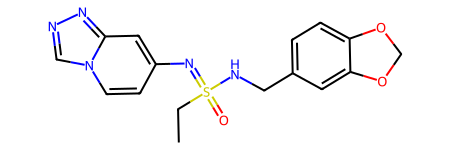

C7273 "v34-MW-mod"

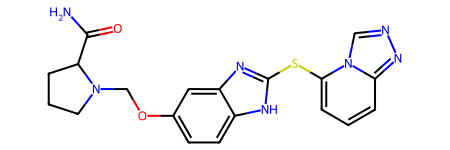

,smiles,hit1,hit2
0,CCS(=O)(=Nc1ccn2cnnc2c1)NCc1ccc2c(c1)OCO2,7gp9-a,B0738a
1,NC(=O)C1CCCN1COc1ccc2[nH]c(Sc3cccc4nncn34)nc2c1,7gpf-a,B1219a


In [93]:
data = []
for smiles, alias, inspirations in manual_designs:
    c = animal.register_compound(smiles=smiles, alias=alias)
    print(c)
    c.draw()
    d = dict(smiles=c.smiles)
    for i,inspiration in enumerate(inspirations):
        pose = animal.poses[inspiration]
        assert pose
        d[f"hit{i+1}"] = pose.name
    data.append(d)

df = pd.DataFrame(data)
df.to_csv("iter1_manuals.csv", index=False)
df

In [92]:
animal.compounds["v25-MW-mod"].poses
animal.compounds["v34-MW-mod"].poses

C7273's poses: {P × 0}

## Parse Curation CSVs

Instruct Fragalysis reviewers to label all their 'picks' as a certain colour. Then populate the dictionary below

In [48]:
csvs = {
    # populate the dictionary:
    # file : (author, selection_colour),
    "../curation/rl_iter1.csv" : ("RL", "green"),
    "../curation/wt_iter1.csv" : ("WT", "blue"),
    "../curation/df_iter1_35.csv" : ("DF", "green"),
    "../curation/df_iter1_36.csv" : ("DF", "green"),
    "../curation/df_iter1_37.csv" : ("DF", "green"),
    "../curation/df_iter1_37.csv" : ("DF", "green"),
    "../curation/mw_iter1_fstein.csv" : ("MW", "green"),
    "../curation/mw_iter1_knit_pure.csv" : ("MW", "green"),
    "../curation/mw_iter1_knit_impure.csv" : ("MW", "green"),
}

In [66]:
yes_tags = set()
for csv, (author, colour) in csvs.items():
    df = pd.read_csv(csv, skiprows=1)
    pset = animal.poses[df[df[colour] == True]["HIPPO Pose ID"]]

    for pose_id, name in { a:b for a,b in df[["HIPPO Pose ID", "name"]].values}.items():
        pose = animal.poses[pose_id]
        if not pose.alias:
            pose.alias = name
        compound = pose.compound
        if not compound.alias:
            compound.alias = name[:-1]
    
    tag = f"{author} curated YES"
    pset.add_tag(tag)
    yes_tags.add(tag)

Tagged {P × 79} w/ "RL curated YES"

Tagged {P × 15} w/ "WT curated YES"

Tagged {P × 21} w/ "DF curated YES"

Tagged {P × 15} w/ "DF curated YES"

Tagged {P × 12} w/ "DF curated YES"

Tagged {P × 24} w/ "MW curated YES"

Tagged {P × 5} w/ "MW curated YES"

Tagged {P × 3} w/ "MW curated YES"

In [67]:
yes_poses = sum((animal.poses(tag=t) for t in yes_tags), animal.poses[set()])
yes_compounds = yes_poses.compounds

In [68]:
for c in yes_compounds:
    poses = c.poses
    tags = [t.removesuffix(" curated YES") for t in poses.tags if "curated" in t]
    print(c, len(tags), ", ".join(tags))

C117 "v76" 1 RL

C157 "v1" 4 MW, WT, RL, DF

C170 "v12" 3 MW, WT, DF

C172 "v17" 2 DF, MW

C174 "v21" 3 MW, WT, DF

C178 "v30" 2 RL, MW

C180 "v32" 3 WT, RL, DF

C182 "v34" 1 DF

C257 "v52" 1 RL

C321 "v56" 1 RL

C407 "v59" 1 RL

C469 "v66" 1 RL

C472 "v3" 2 RL, MW

C475 "v4" 1 MW

C477 "v7" 2 RL, WT

C479 "v9" 2 RL, MW

C481 "v11" 2 RL, DF

C485 "v16" 2 RL, WT

C487 "v19" 1 WT

C488 "v22" 2 RL, MW

C491 "v26" 2 RL, WT

C492 "v29" 2 RL, WT

C493 "v31" 1 MW

C494 "v33" 3 MW, WT, RL

C495 "v35" 2 RL, MW

C497 "v38" 2 RL, MW

C498 "v40" 1 MW

C499 "v42" 2 RL, MW

C500 "v44" 2 RL, MW

C501 "v46" 2 RL, MW

C707 "v57" 1 RL

C759 "v61" 1 RL

C824 "v65" 1 RL

C839 "v68" 1 RL

C841 "v69" 1 RL

C898 "v70" 1 RL

C900 "v71" 1 RL

C933 "v73" 1 RL

C962 "v75" 1 RL

C1033 "v77" 1 RL

C1043 "v79" 2 RL, MW

C1097 "v82" 2 RL, DF

C1098 "v83" 1 DF

C1100 "v84" 2 RL, DF

C1101 "v86" 2 RL, DF

C1121 "v87" 2 RL, DF

C1122 "v89" 2 RL, DF

C1125 "v90" 2 RL, DF

C1280 "v94" 1 RL

C1708 "v129" 1 RL

C1770 "v130" 1 RL

C1811 "v134" 1 RL

C2022 "v98" 1 RL

C2074 "v99" 1 RL

C2096 "v100" 2 RL, MW

C2134 "v102" 2 RL, MW

C2138 "v103" 1 RL

C2702 "v146" 1 RL

C2712 "v148" 1 RL

C2742 "v150" 1 RL

C2845 "v154" 2 RL, MW

C3182 "v106" 1 DF

C3183 "v107" 1 DF

C3209 "v112" 2 RL, MW

C3233 "v116" 1 DF

C3251 "v119" 3 MW, RL, DF

C3254 "v120" 1 RL

C3264 "v126" 3 MW, RL, DF

C3324 "v132" 1 DF

C3360 "v135" 1 DF

C3495 "v143" 1 RL

C3992 "v160" 1 MW

C3994 "v161" 1 RL

C3996 "v162" 1 RL

C4029 "v163" 1 MW

C4044 "v164" 1 RL

C4445 "v97" 1 RL

C5312 "v176" 1 DF

C5314 "v177" 1 DF

C5315 "v178" 2 RL, DF

C5316 "v179" 1 DF

C5327 "v183" 2 RL, DF

C5856 "v104" 2 RL, DF

C5867 "v108" 2 RL, DF

C5868 "v109" 2 RL, DF

C5906 "v113" 2 RL, DF

C5911 "v114" 1 RL

C6162 "v152" 1 DF

C6421 "v159" 1 RL

C6717 "v186" 1 RL

C6727 "v187" 1 RL

C7035 "v169" 1 RL

C7036 "v171" 1 RL

C7068 "v172" 1 RL

C7190 "v174" 2 RL, DF

C7247 "v188" 2 RL, DF

C7248 "v191" 1 DF

In [29]:
pset.interactive()

Output()

# Export SMILES for Chem Review

In [7]:
animal.tags.unique

{'BulkDock Fragalysis export',
 'Fragmenstein placed',
 '[Other] iter1_frags',
 '[Other] upload_1 2025-02-11',
 'hits'}

In [11]:
scaffolds = animal.poses(tag="BulkDock Fragalysis export").compounds
scaffolds.add_tag("iter1 exported merges")
scaffolds.write_smiles_csv("iter1_merges.csv")

Tagged {C × 148} w/ "iter1 exported merges"

 DISK  Writing iter1_merges.csv...